In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent
import pprint



[22:05:01 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '195136', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195138', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195137', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211044', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195139', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211045', 'name': 'Games', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195141', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195135', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195140', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211046', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '195142', 'name': '_frontend', 'system': True, 'type': 'docu

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[22:05:05 -0600] [INFO]: Graph 'SteamGraph' exists.
[22:05:05 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [7]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jQtSiR2---', 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Games/14242_9_03m Games/14242_9_03m
Users/89524281 Users/89524281
Games/13699_the_flame_in_the_flood Games/13699_the_flame_in_the_flood
Users/96149161 Users/96149161
Games/11661_quantum_conundrum Games/11661_quantum_conundrum
Games/12461_epic_cards_battle_tcg Games/12461_epic_cards_battle_tcg
Games/13889_why_so_evil_2_dystopia Games/13889_why_so_evil_2_dystopia
Users/145646661 Users/145646661
Users/127813787 Users/127813787
Games/13446_cabelas_trophy_bucks Games/13446_cabelas_trophy_bucks


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_analyzers
_queues
_aqlfunctions
Users
_jobs
Games
_appbundles
_graphs
_apps
plays
_frontend

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '279204362', '_id': 'Users/279204362', '_rev': '_jPaYbim-AX', 'type': 'Users', 'steamid': 279204362}
{'_key': '77903318', '_id': 'Users/77903318', '_rev': '_jPaYbjG-_z', 'type': 'Users', 'steamid': 77903318}
{'_key': '202480747', '_id': 'Users/202480747', '_rev': '_jPaYbjm--n', 'type': 'Users', 'steamid': 202480747}
----------
Sample Plays Edges:
{'_key': '14100', '_id': 'plays/14100', '_from': 'Users/206014489', '_to': 'Games/12599_gas_guzzlers_extreme', '_rev': '_jPaYf3C--I', 'weight': 60}
{'_key': '29456', '_id': 'plays/29456', '_from': 'Users/102831764', '_to': 'Games/11627_smite', '_rev': '_jPaYgu2--h', 'weight': 2.6}
{'_key': '56921', '_id': 'plays/56921', '_from': 'Users/10934310', '_to': 'Games/11427_half_life_2', '_rev': '_jPaYiNq--R', 'weight': 1.1}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


In [13]:
# If the schema is exposed as an attribute
graph_schema = arango_graph.schema
pprint.pprint(graph_schema)


{'Collection Schema': [{'collection_name': 'Users',
                        'collection_type': 'document',
                        'document_properties': [{'name': '_key', 'type': 'str'},
                                                {'name': '_id', 'type': 'str'},
                                                {'name': '_rev', 'type': 'str'},
                                                {'name': 'type', 'type': 'str'},
                                                {'name': 'steamid',
                                                 'type': 'int'}],
                        'example_document': {'_id': 'Users/151603712',
                                             '_key': '151603712',
                                             '_rev': '_jPaYbhm---',
                                             'steamid': 151603712,
                                             'type': 'Users'}},
                       {'collection_name': 'Games',
                        'collection_type': 'docu

In [14]:
result_cursor =  G_adb.query("""
WITH Games, plays
FOR game IN Games 
  LET playerCount = (
    FOR play IN plays 
    FILTER play._to == game._id 
    COLLECT WITH COUNT INTO length 
    RETURN length
  )[0] 
  SORT playerCount DESC 
  LIMIT 1 
  RETURN {game, playerCount: playerCount}
""")

for item in result_cursor:
    print(item)
print('-'*10)



{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jPaYcPq--B', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}
----------


In [15]:
arango_graph

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


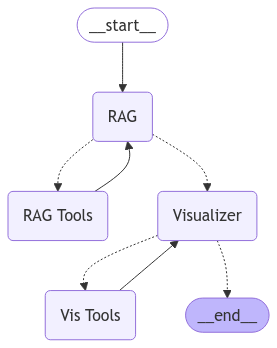

In [16]:
agent = GraphAgent(arango_graph, G_adb)


In [19]:
def create_gradio_interface(agent):
    def display_response(input_text):
        result = agent.query_graph(input_text)
        print("Inside interface")
        print(result["html_code"])
        return (
            result["html_code"],
            result["reply"]
        )
    
    css = """
        #visualization-container {
            width: 100%;
            margin: 0;
            padding: 0;
        }
        #visualization-container iframe {
            width: 100%;
            height: 600px;
            border: none;
        }
    """
    
    with gr.Blocks(css=css) as interface:
        gr.Markdown("# Graph Analysis Interface")
        
        with gr.Column():
            input_text = gr.Textbox(
                label="Query",
                placeholder="Enter your graph query here...",
                lines=2
            )
            
            submit_btn = gr.Button("Analyze", variant="primary")
            
            html_output = gr.HTML(
                label="Visualization",
                value="",
                elem_id="visualization-container"
            )
            
            text_output = gr.Textbox(
                label="Analysis Result", 
                lines=3
            )
            
        submit_btn.click(
            fn=display_response,
            inputs=[input_text],
            outputs=[html_output, text_output]
        )
    
    return interface

In [20]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.



Processing Agent State:
{ 'data': [],
  'graph_schema': { 'Collection Schema': [ { 'collection_name': 'Users',
                                             'collection_type': 'document',
                                             'document_properties': [ { 'name': '_key',
                                                                        'type': 'str'},
                                                                      { 'name': '_id',
                                                                        'type': 'str'},
                                                                      { 'name': '_rev',
                                                                        'type': 'str'},
                                                                      { 'name': 'type',
                                                                        'type': 'str'},
                                                                      { 'name': 'steamid',
                  

In [18]:
response = agent.query_graph("Total number of games in the graph")


Processing Agent State:
{ 'data': [],
  'graph_schema': { 'Collection Schema': [ { 'collection_name': 'Users',
                                             'collection_type': 'document',
                                             'document_properties': [ { 'name': '_key',
                                                                        'type': 'str'},
                                                                      { 'name': '_id',
                                                                        'type': 'str'},
                                                                      { 'name': '_rev',
                                                                        'type': 'str'},
                                                                      { 'name': 'type',
                                                                        'type': 'str'},
                                                                      { 'name': 'steamid',
                  

In [ ]:
agent.query_graph("Users who have played the most influential game")


Processing Agent State:
{ 'data': [],
  'iframe_html': '',
  'messages': [ HumanMessage(content='Users who have played the most influential game', additional_kwargs={}, response_metadata={}, id='32095d7a-448c-4953-86fc-7477c6e1e341')],
  'user_query': 'Users who have played the most influential game'}
Netwrokx Query received:
What is the most influential game based on network centrality metrics?
----------
1) Generating NetworkX code
----------
import networkx as nx

# Get all game nodes
game_nodes = [node for node, attr in G_adb.nodes(data=True) if 'Games/' in node]

# Calculate different centrality metrics for games
degree_cent = nx.degree_centrality(G_adb)
betweenness_cent = nx.betweenness_centrality(G_adb)
eigenvector_cent = nx.eigenvector_centrality(G_adb, max_iter=1000)

# Create combined score for each game
game_scores = {}
for game in game_nodes:
    score = degree_cent[game] + betweenness_cent[game] + eigenvector_cent[game]
    game_scores[game] = score

# Get game with highe

[19:41:37 -0600] [INFO]: Graph 'SteamGraph' load took 2.4515597820281982s
[19:41:39 -0600] [INFO]: Graph 'SteamGraph' load took 2.53513765335083s


In [14]:
agent.query_graph("Find 2nd and 4th Most influential game in the graph and its number of users who played both of them")


Processing Agent State:
{ 'data': [],
  'messages': [ HumanMessage(content='Find 2nd and 4th Most influential game in the graph and its number of users who played both of them', additional_kwargs={}, response_metadata={}, id='800e2839-3631-462e-940b-74ec1e2c2b3c')],
  'user_query': 'Find 2nd and 4th Most influential game in the graph and its '
                'number of users who played both of them'}

Processing Agent State:
{ 'data': [],
  'messages': [ HumanMessage(content='Find 2nd and 4th Most influential game in the graph and its number of users who played both of them', additional_kwargs={}, response_metadata={}, id='800e2839-3631-462e-940b-74ec1e2c2b3c'),
                AIMessage(content="To address the query, we need to follow these steps:\n\n1. **Identify the Most Influential Games**: Use centrality measures to determine the influence of games in the graph. We will use NetworkX to calculate the centrality of each game and identify the 2nd and 4th most influential games.\n\n

'Visulaization Done'

In [ ]:
agent.query_graph("Find the  top 10 users who played a lot  and which games they have played is common most by hours")


Processing Agent State:
{ 'messages': [ HumanMessage(content='Find the  top 10 users who played a lot  and which games they have played is common most by hours', additional_kwargs={}, response_metadata={}, id='f215f92d-4d51-4083-a4f8-0ea346a4fac7')],
  'user_query': 'Find the  top 10 users who played a lot  and which games they '
                'have played is common most by hours'}


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Users, Games, plays
FOR user IN Users
    LET total_hours = SUM(
        FOR play IN plays
            FILTER play._from == user._id
            RETURN play.weight
    )
    SORT total_hours DESC
    LIMIT 10
    RETURN { user_id: user._key, total_hours: total_hours }

AQL Result:
[{'user_id': '73017395', 'total_hours': 11754}, {'user_id': '10599862', 'total_hours': 11651.699999999999}, {'user_id': '100630947', 'total_hours': 10853.2}, {'user_id': '26762388', 'total_hours': 10470.100000000004}, {'user_id': '153382649', 'total_hours': 9640}, 

"Here are the top games most commonly played by the top 10 users based on total hours:\n\n1. **Sid Meier's Civilization V**: 13,197 hours\n2. **Dota 2**: 10,790.4 hours\n3. **Team Fortress 2**: 9,724.7 hours\n4. **Counter-Strike: Global Offensive**: 5,434.6 hours\n5. **Mount & Blade: Warband**: 4,962 hours\n\nThese games are the most popular among the top 10 users with the highest playtime, indicating their gaming preferences."

In [18]:
agent.query_graph("get me 10 random users")


Processing Agent State:
{ 'data': [],
  'graph_schema': { 'Collection Schema': [ { 'collection_name': 'Users',
                                             'collection_type': 'document',
                                             'document_properties': [ { 'name': '_key',
                                                                        'type': 'str'},
                                                                      { 'name': '_id',
                                                                        'type': 'str'},
                                                                      { 'name': '_rev',
                                                                        'type': 'str'},
                                                                      { 'name': 'type',
                                                                        'type': 'str'},
                                                                      { 'name': 'steamid',
                  

{'html_code': <gradio.components.html.HTML at 0x7c8e4b5d06d0>,
 'reply': "I've created a visualization of the 10 random users. The visualization should show each user as a node, represented by their Steam ID. This gives you a clear visual representation of the random sample of users from the database. Each node represents a unique user in the system, identified by their Steam ID number.\n\nIs there anything specific about these users you'd like to explore or visualize differently?"}